In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
from scipy import io

import glmnet_python
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

from PIL import Image
from sklearn.model_selection import train_test_split,KFold
from pyglmnet import GLM, GLMCV, datasets, utils

In [2]:
""" 
Obtaining data from a given expt
"""
Test = pd.read_csv('../auditory_categorization_longLow/important_things_not_included_in_assets/allTrials.csv');
Data = pd.read_csv('auditory_categorization_lc_online_data/auditory_categorization_v2_119865_2021-10-06_15h14.51_d5be8c24-8f3b-475d-85e1-ae3f097e030c/6138cf1c55fe1a3ccbbe4fc3_categorization_task_longLow_2021-10-04_00h41.47.197.csv');

In [3]:
def extractData(csv_test, csv_data, exptTotalLength, exptLengthWithBreaks):   
    n_trials = csv_data.shape[0]-47

    test_columns = list(csv_test.columns)
    test_tones_name = test_columns.index('Name')
    test_tones_col_idx = test_columns.index('Tones')
    df_names = (csv_test.iloc[0:exptTotalLength,test_tones_name]).values
    df_tones = (csv_test.iloc[0:exptTotalLength,test_tones_col_idx]).values

    tones_array_orig = np.zeros((n_trials,n_tones))
    tones_array_idxs_keep = []

    for i_wav in range(exptLengthWithBreaks):
        if isinstance(csv_data['Name'][i_wav+46],str):
            tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]\
                                                              ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            tones_array_idxs_keep += [i_wav]


    exptTones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
    exptCorrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    exptKeys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    
    return exptTones, exptCorrans, exptKeys

n_tones = 3

"""
Get tones and values of keys pressed from no context expt
"""
df_tones, df_corrans, df_keys = extractData(csv_test=Test, 
                                            csv_data=Data, 
                                            exptTotalLength=800, 
                                            exptLengthWithBreaks=804)    

    

In [4]:
def identifyResponseTrials(keysPressed, correctAns, tonesPlayed, exptTotalLength):
    no_response = np.intersect1d(np.where(keysPressed!='h')[0],
                                 np.where(keysPressed!='l')[0])
    print("Did not respond to: ",no_response)

    """
    Convert keys ['l','h'] to [0,1]
    """

    corrans_num_orig = np.zeros_like(correctAns)
    corrans_num_orig[correctAns == 'h'] = 1

    keys_num_orig = np.zeros_like(keysPressed)
    keys_num_orig[keysPressed == 'h'] = 1

    corrans_num = corrans_num_orig[:exptTotalLength]
    keys_num = keys_num_orig[:exptTotalLength]
    tones_array = tonesPlayed[:exptTotalLength]
    print("Got correct: ", np.sum(keys_num==corrans_num)/len(tones_array))
    print("No. of minority category correct: ", np.sum(keys_num*corrans_num)/np.sum(corrans_num))

    trial_tones = np.repeat(tones_array,1,axis = 0)
    trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
    idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
    trialTonesResponded = trial_tones[idxs_with_response,:]
    trialBehaviourResponded = trial_behaviour[idxs_with_response]
    corransResponded = corrans_num[idxs_with_response]
    print(f"Total trials played are {len(trial_tones)}, and total trials responded to are {len(trialTonesResponded)}")
    
    return trialTonesResponded, trialBehaviourResponded, corransResponded

"""
Find no response cases in the no context expt
"""
trial_tones_expt, trial_behaviour_expt, corrans_expt = identifyResponseTrials(keysPressed = df_keys, 
                                                                            correctAns = df_corrans, 
                                                                            tonesPlayed = df_tones, 
                                                                            exptTotalLength = 800)

    

Did not respond to:  [303]
Got correct:  0.835
No. of minority category correct:  0.7669491525423728
Total trials played are 800, and total trials responded to are 799


In [5]:
expt_tones = np.arange(90,3000,1) #array of possible true tones
log_freq_seq_array = np.arange(0.6,4.7,0.1)
log_freq_percept = np.arange(0.6,4.7,0.1) # array of possible perceptual tones

def betaValuesSim(tones_array,keys_num,
                  alpha,noTau, 
                  permutations):
    
    glmBetas = np.zeros((permutations,31))
    betas = np.zeros((permutations,31))
    GLMScoreTt = 0
    PyGLMScoreTt = 0
    
    kf = KFold(n_splits=permutations)
    nn = 0
    
    for train_index, test_index in kf.split(tones_array):
        # print("TEST:", test_index)
        Xtrain, Xtest = tones_array[train_index,:], tones_array[test_index,:]
        ytrain, ytest = keys_num[train_index], keys_num[test_index]
    
        """
        Train Variables
        """
        trial_tonesTr = np.repeat(Xtrain,1,axis = 0)
        trial_behaviourTr = np.reshape(ytrain,np.prod(ytrain.shape)) 

        """
        Creating lookup table
        """
        uniqueTonesTr = np.unique(tones_array)
        freqTableTr = np.zeros((len(trial_tonesTr),len(uniqueTonesTr)))
        for ii in range(len(trial_tonesTr)):
            for jj in trial_tonesTr[ii]:
                freqTableTr[ii,np.where(uniqueTonesTr==jj)] += 1        

        """
        Test Variables
        """
        trial_tonesTt = np.repeat(Xtest,1,axis = 0)
        trial_behaviourTt = np.reshape(ytest,np.prod(ytest.shape)) 

        """
        Creating lookup table
        """
        uniqueTonesTt = np.unique(tones_array)
        freqTableTt = np.zeros((len(trial_tonesTt),len(uniqueTonesTt)))
        for ii in range(len(trial_tonesTt)):
            for jj in trial_tonesTt[ii]:
                freqTableTt[ii,np.where(uniqueTonesTt==jj)] += 1       

        """
        Cross-validation using glmnet
        """
        plt.figure()
        cvfit = cvglmnet(x = freqTableTr, y = trial_behaviourTr.astype(float),
                         family = 'binomial', ptype = 'class', alpha=alpha)

        #Results of fit
        cvglmnetPlot(cvfit)
        betas[nn] = cvglmnetCoef(cvfit, s='lambda_min').flatten()
        GLMScoreTt += sum(cvglmnetPredict(cvfit, newx=freqTableTt, s='lambda_min', ptype='class').flatten()
                          ==trial_behaviourTt)/len(trial_behaviourTt)

        """
        Cross-validation using pyglmnet
        """

        n_samples = freqTableTr.shape[0]
        """
        tau possibilities 
        """
        #Tau = utils.tikhonov_from_prior(prior_cov, n_samples)

        Tau = np.zeros((len(uniqueTonesTr),len(uniqueTonesTr)))
        for ii in range(len(uniqueTonesTr)):
            Tau[ii,ii] = 2
            if ii < len(uniqueTonesTr)-1:
                Tau[ii,ii+1] = -0.5-1
            if ii > 0:
                Tau[ii,ii-1] = -0.5

        # use the default value for reg_lambda
        glm = GLMCV(distr='binomial', alpha=alpha, Tau=(1-noTau)*Tau[1:-1,:], score_metric='accuracy',tol=1e-4,
                   max_iter=3000)
                
        # fit model
        glm.fit(freqTableTr, trial_behaviourTr.astype(float))

        # score the test set prediction
        #print("PyGLMNet train score: %f" % glm.score(freqTableTr, trial_behaviourTr))
        PyGLMScoreTt += glm.score(freqTableTt, trial_behaviourTt)

        glmBetas[nn,0] = glm.beta0_
        glmBetas[nn,1:] = glm.beta_
        
        nn+=1
    
    print(alpha, [GLMScoreTt/permutations, PyGLMScoreTt/permutations])
    
    return(uniqueTonesTr, betas, np.array(glmBetas), GLMScoreTt/permutations, PyGLMScoreTt/permutations)

/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.0 [0.8572626582278483, 0.8635284810126583]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.1 [0.8534968354430381, 0.8434651898734178]


<ipython-input-5-f57aad49f320>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: Mat

0.2 [0.855996835443038, 0.8472468354430379]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.30000000000000004 [0.853481012658228, 0.8297310126582278]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.4 [0.8522310126582278, 0.8172468354430379]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.5 [0.852231012658228, 0.8009968354430379]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.6000000000000001 [0.8522310126582278, 0.7922468354430379]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.7000000000000001 [0.8522310126582278, 0.7696835443037975]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.8 [0.8509810126582279, 0.7459335443037973]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.9 [0.8535126582278482, 0.7296518987341771]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

1.0 [0.852246835443038, 0.7159018987341772]


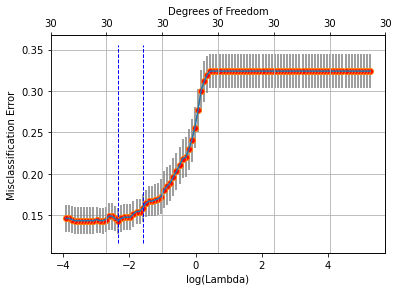

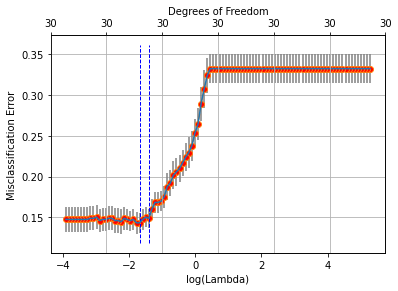

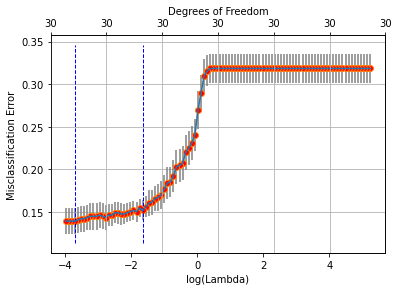

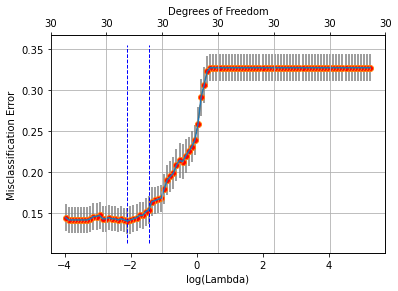

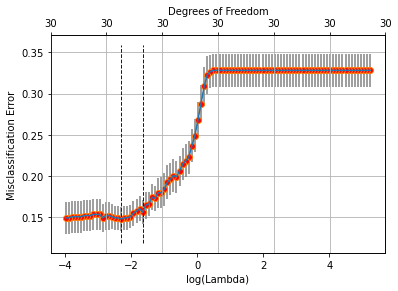

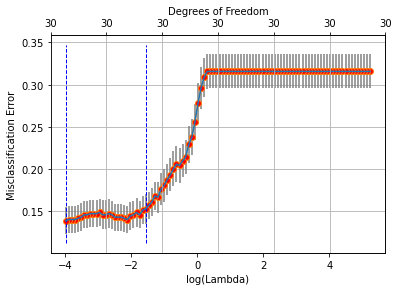

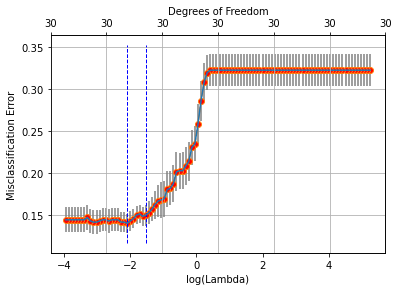

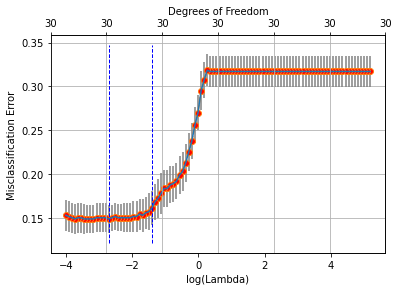

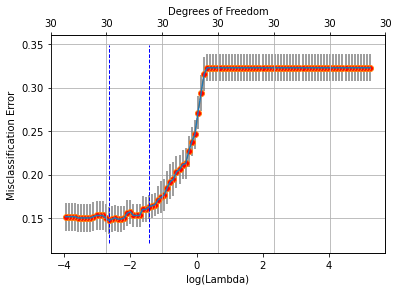

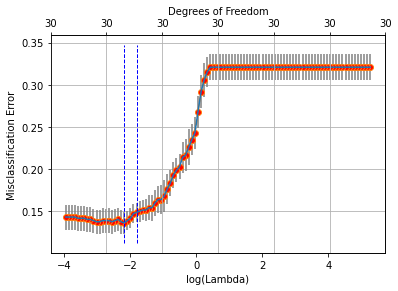

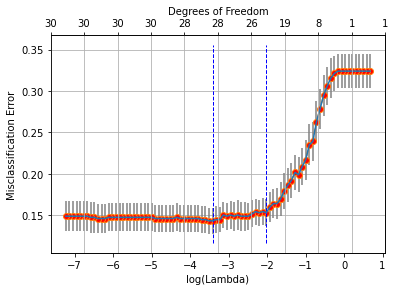

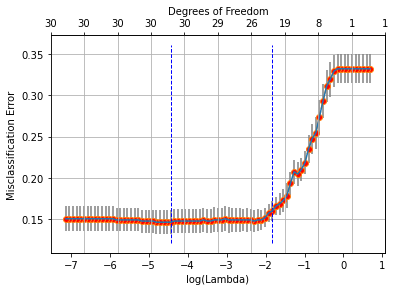

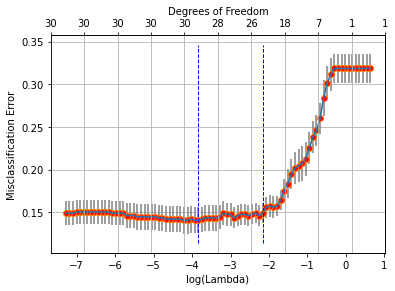

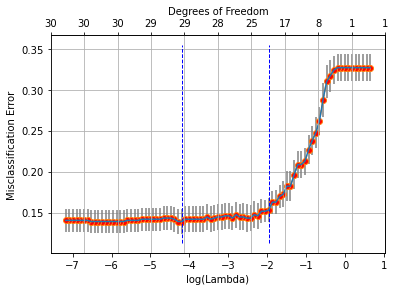

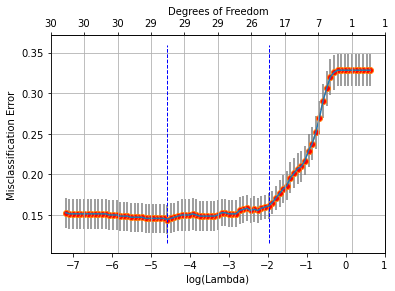

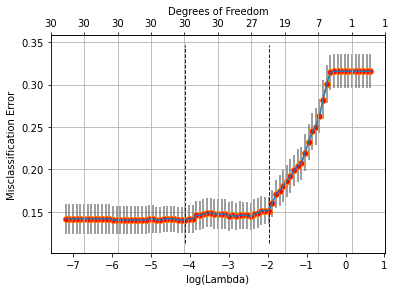

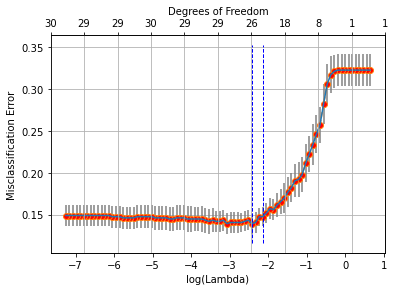

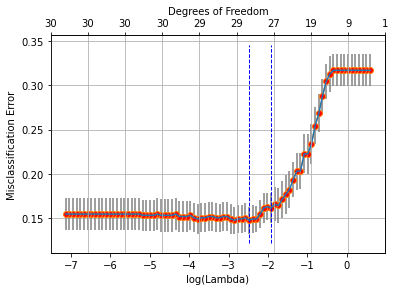

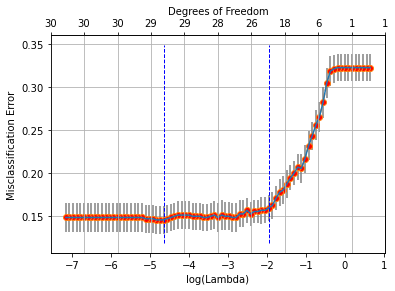

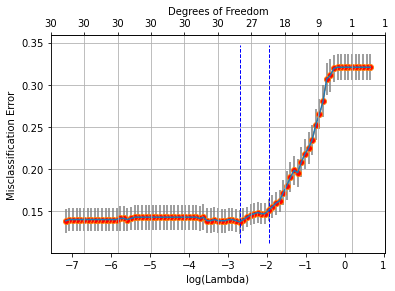

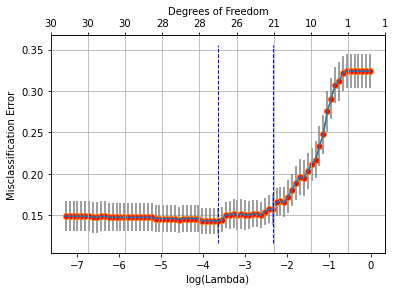

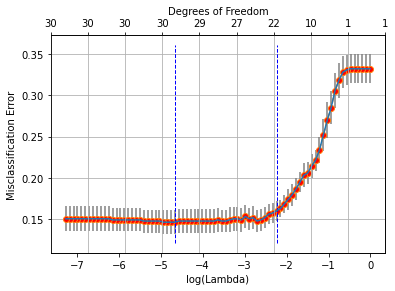

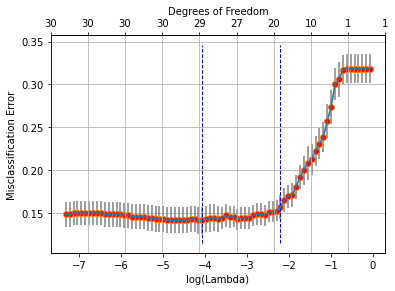

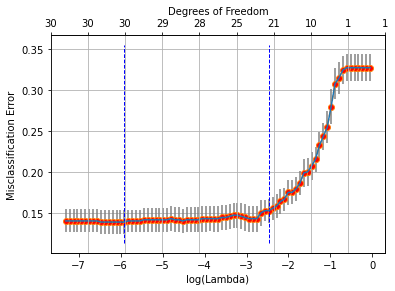

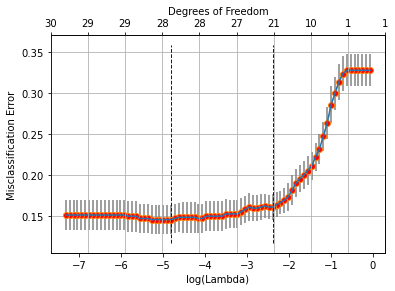

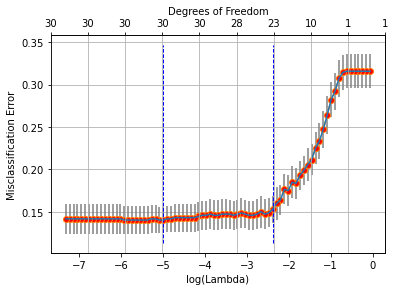

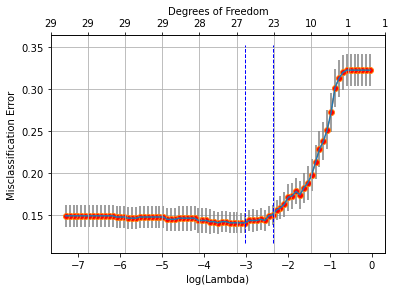

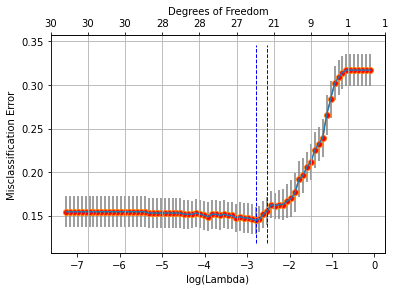

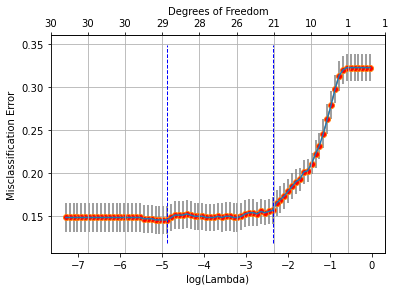

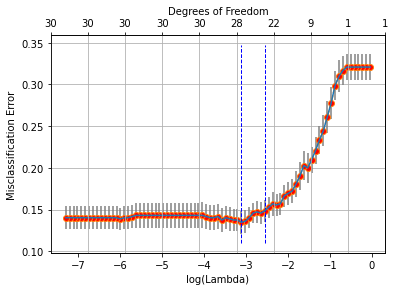

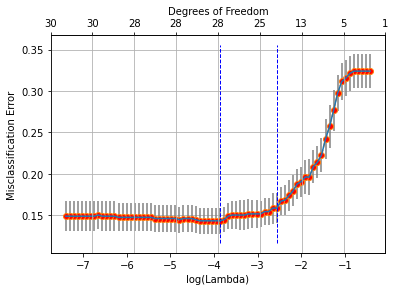

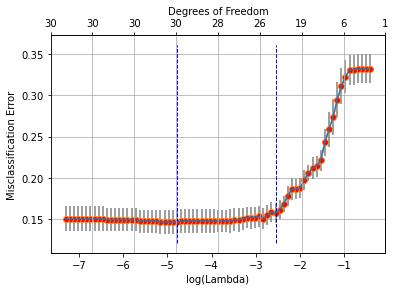

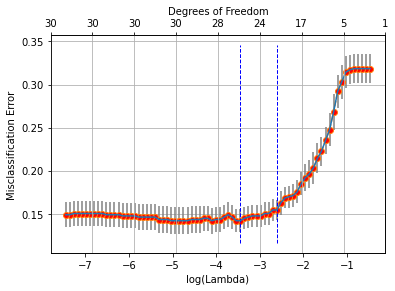

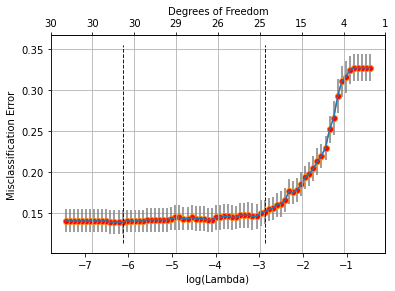

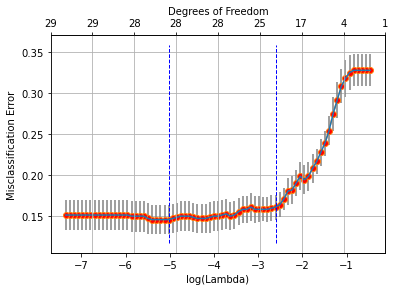

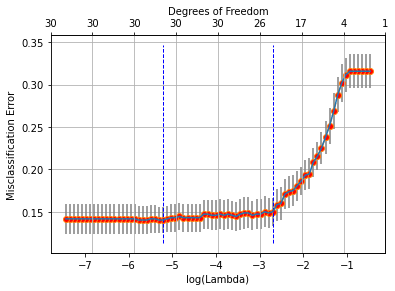

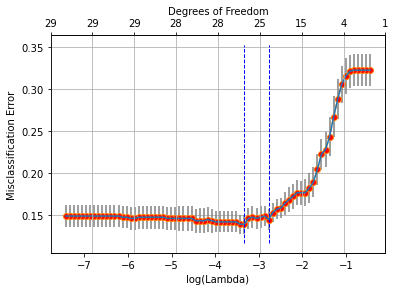

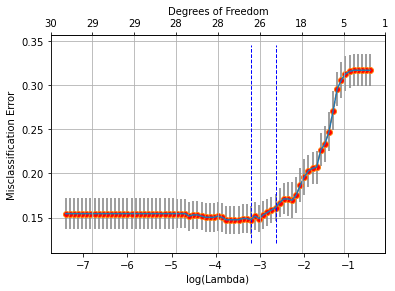

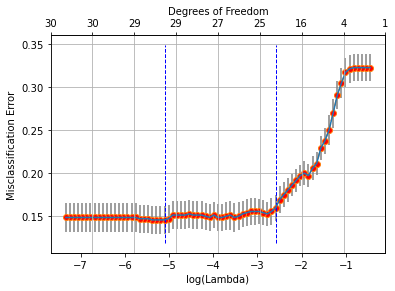

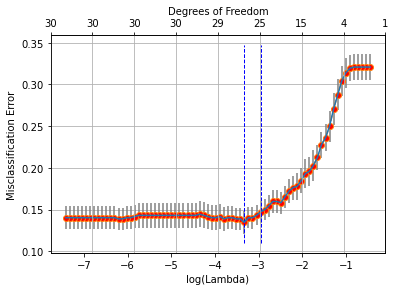

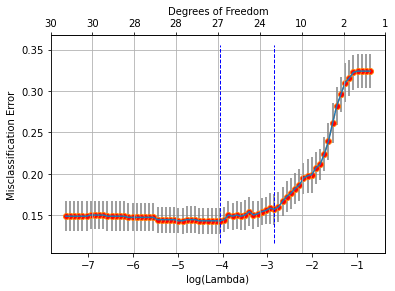

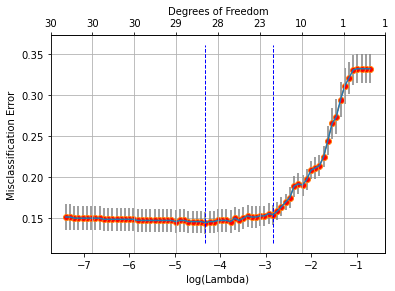

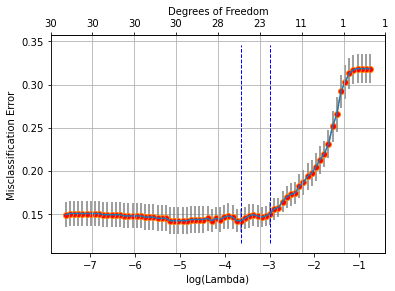

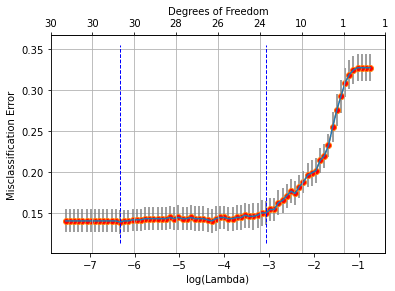

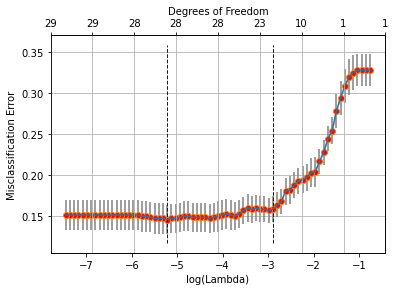

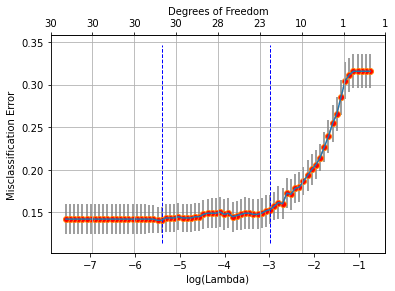

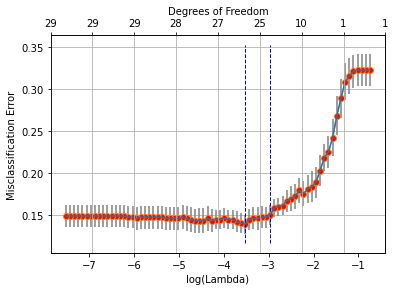

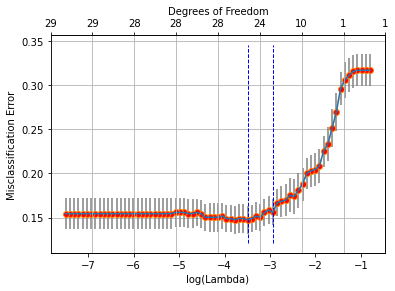

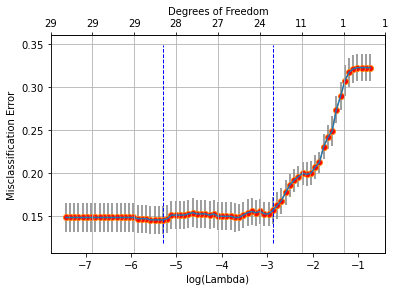

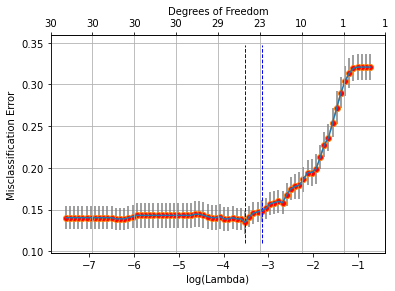

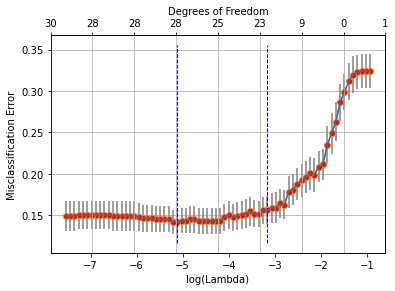

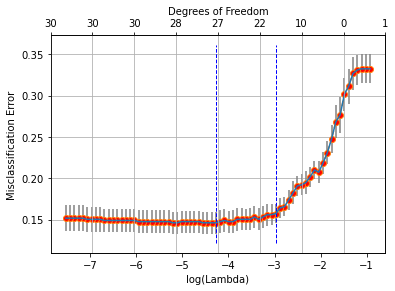

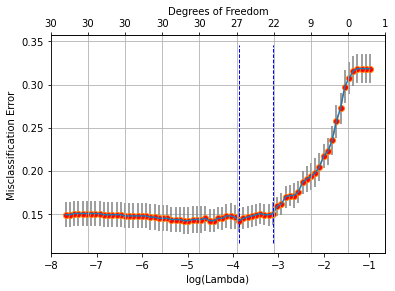

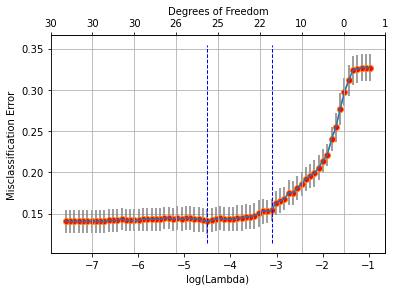

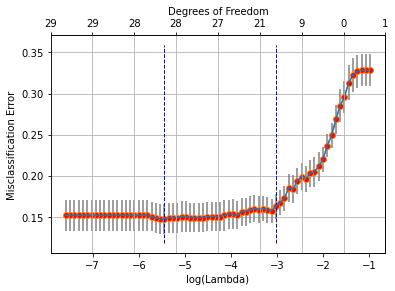

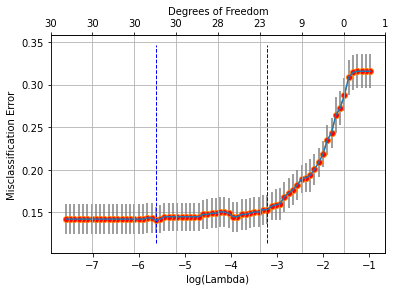

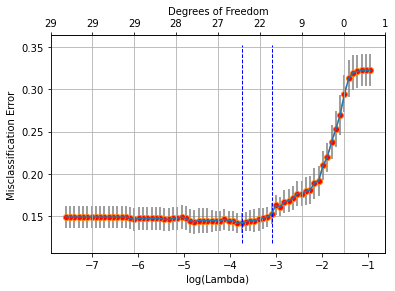

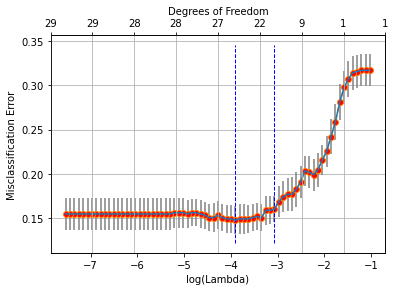

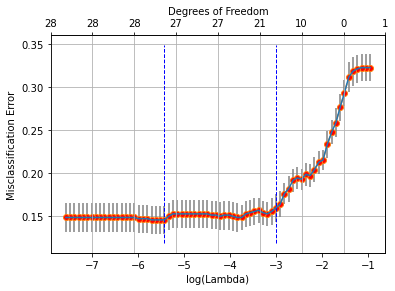

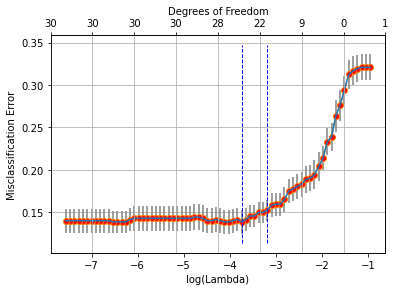

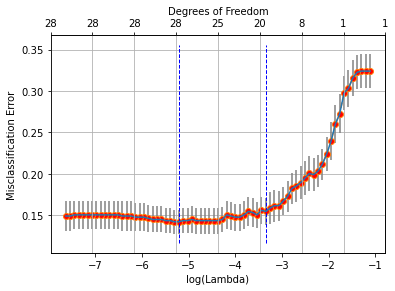

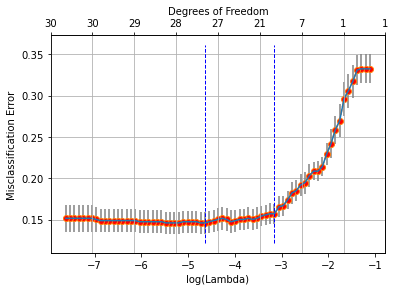

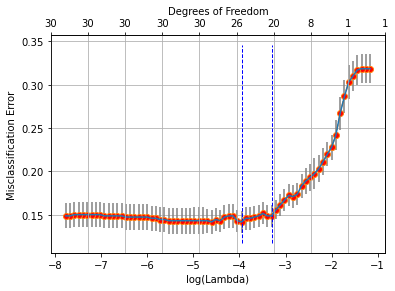

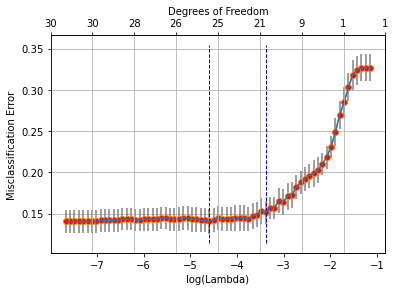

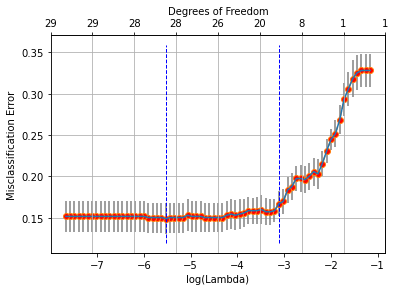

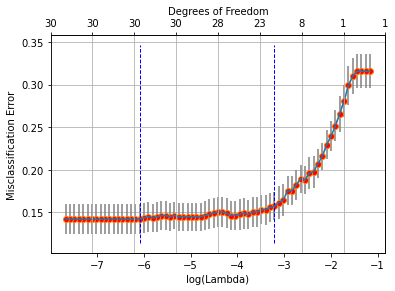

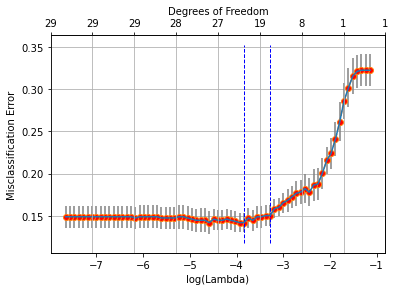

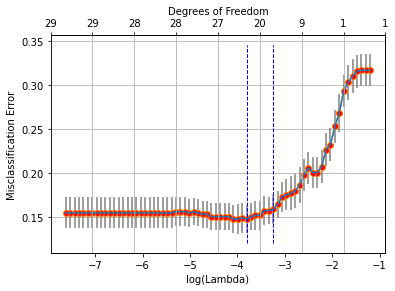

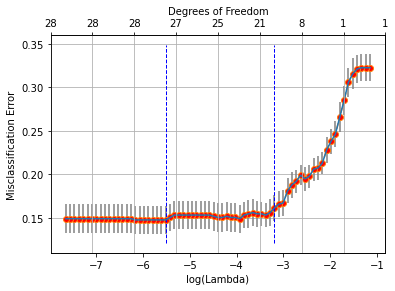

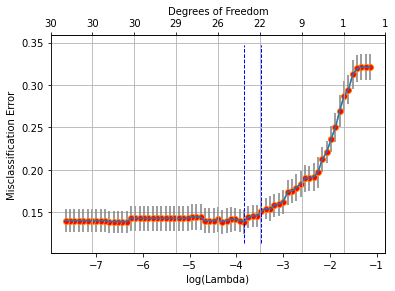

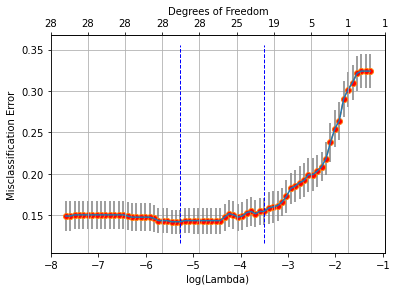

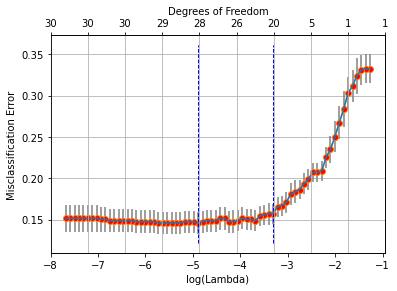

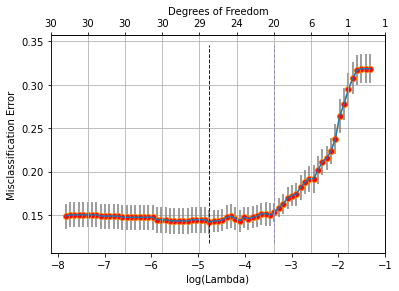

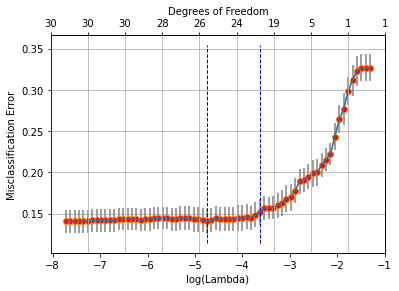

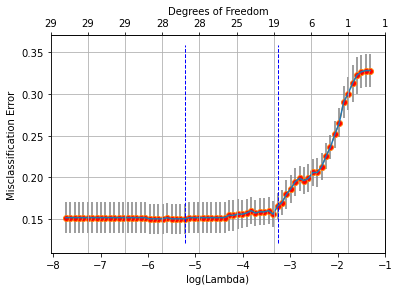

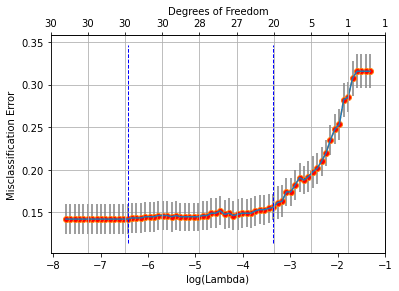

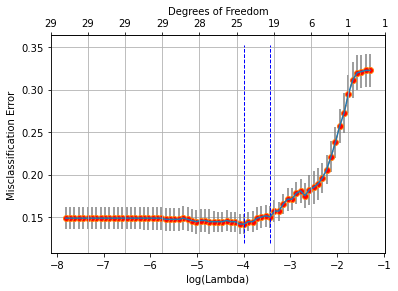

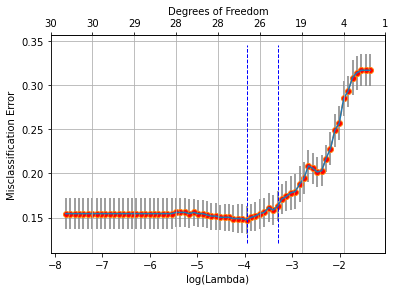

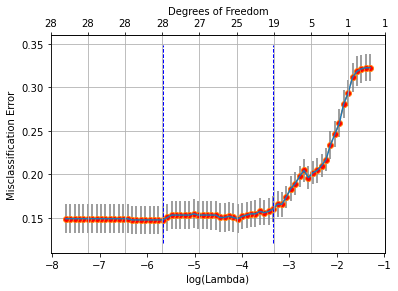

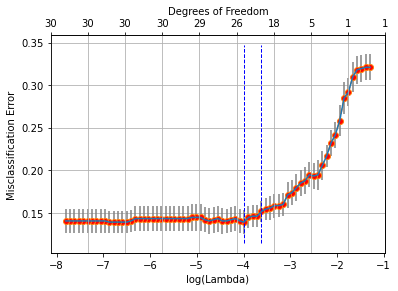

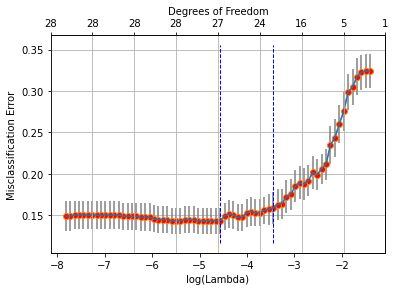

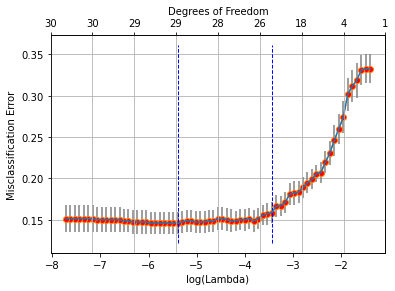

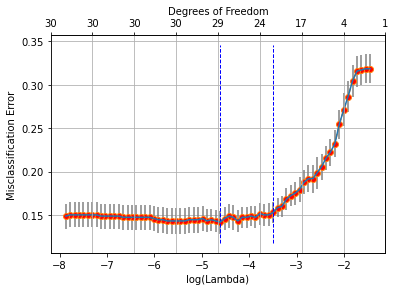

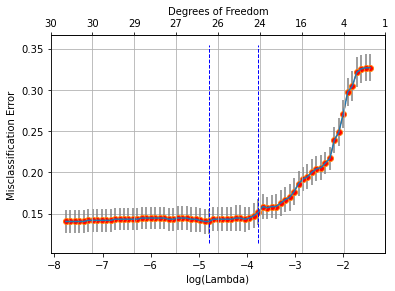

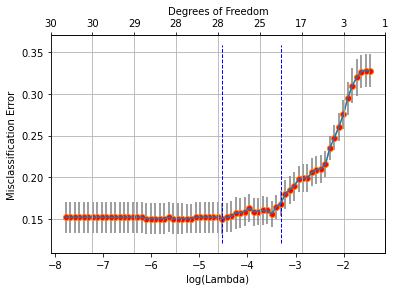

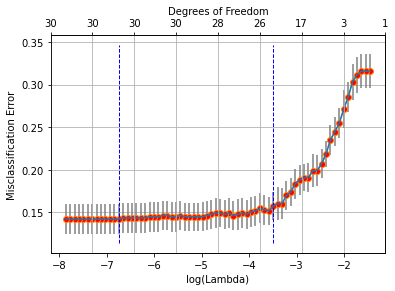

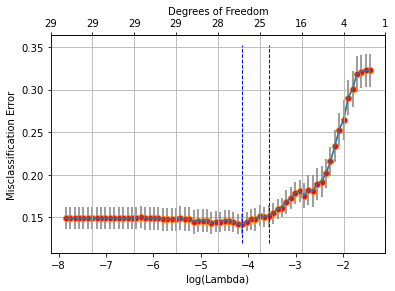

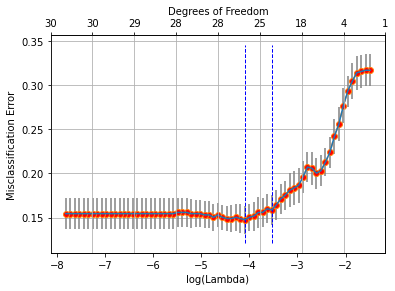

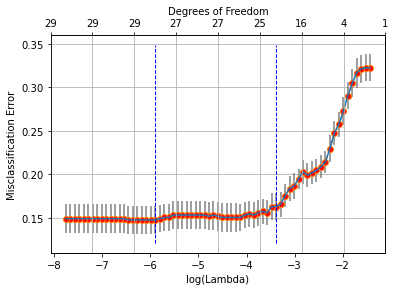

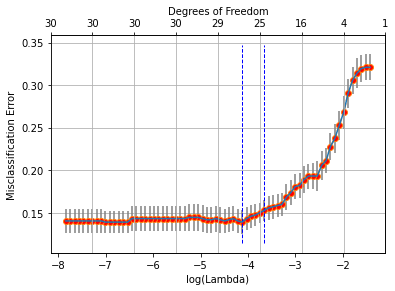

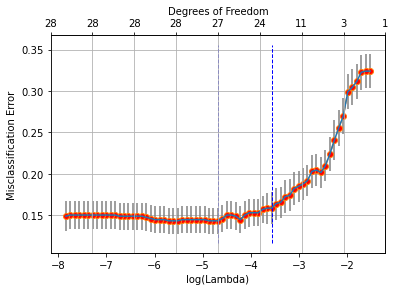

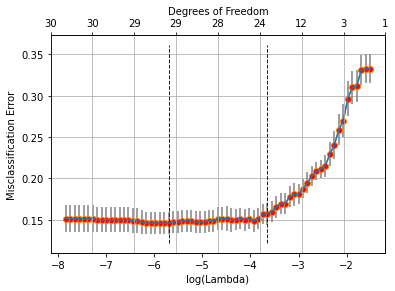

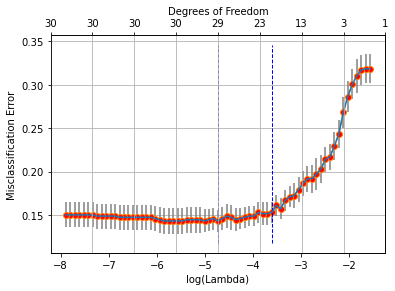

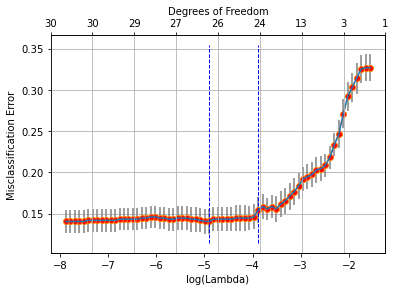

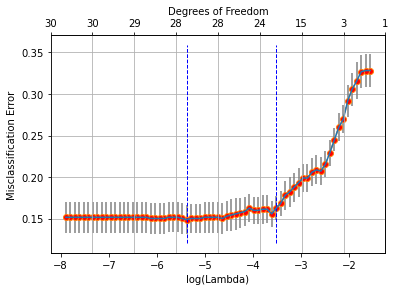

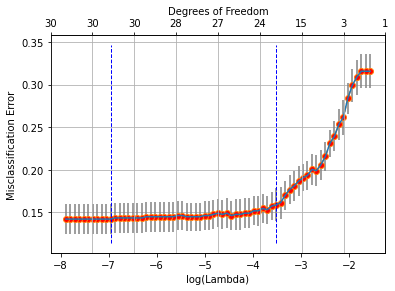

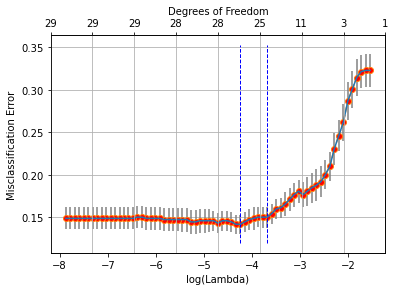

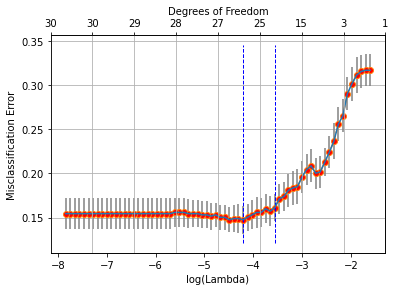

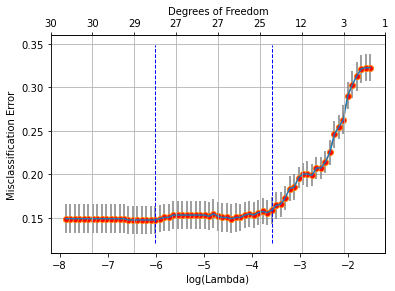

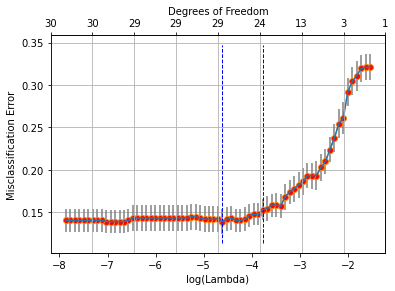

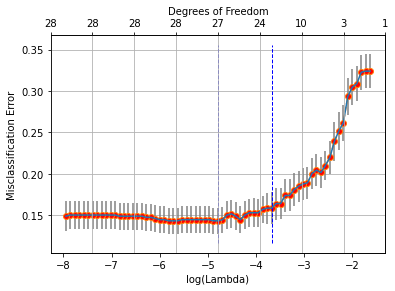

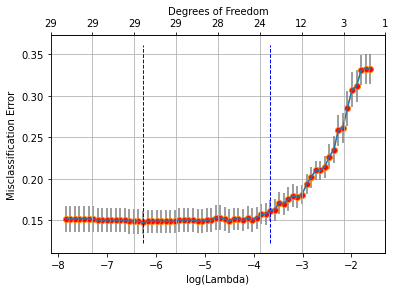

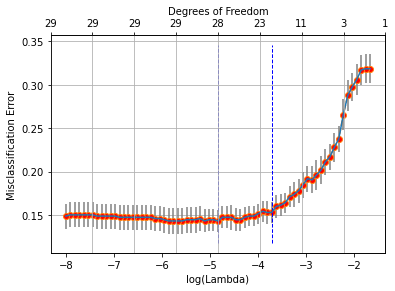

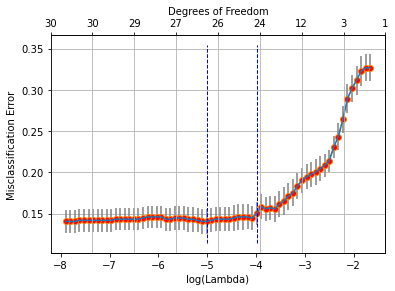

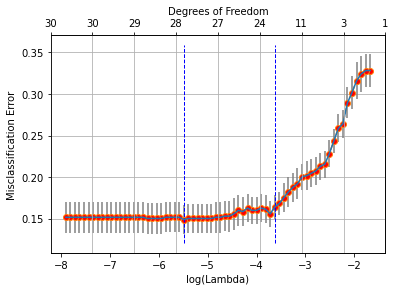

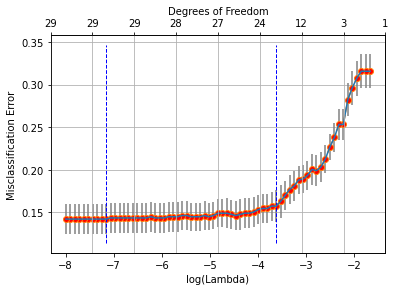

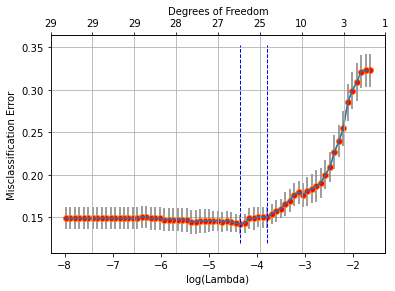

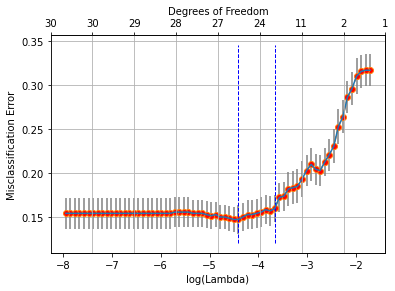

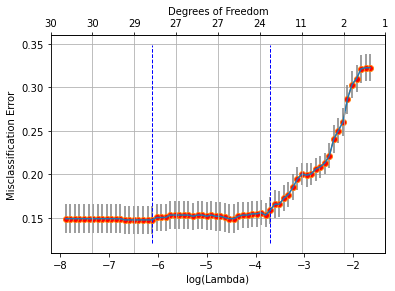

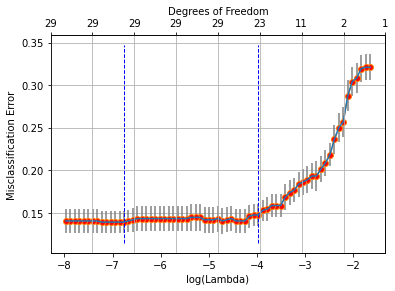

In [6]:
"""
Comparing both contexts for simulated behaviour
"""
GLMscore_long = np.zeros((11,1))
PyGLMscore_long = np.zeros((11,1))

for ialpha in range(0,11):
    [_, betasSmall_long, pyGLMbetasSmall_long,
    GLMscore_long[ialpha], PyGLMscore_long[ialpha]] = betaValuesSim(trial_tones_expt,
                                                                 trial_behaviour_expt,
                                                                 alpha = ialpha*0.1,
                                                                 noTau=0, 
                                                                 permutations=10)



/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.0 [0.8572626582278483, 0.8672784810126583]


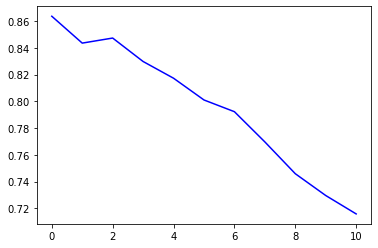

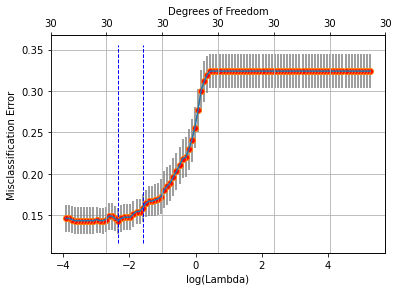

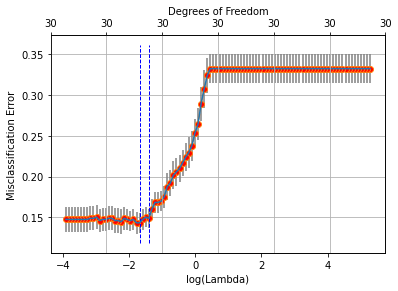

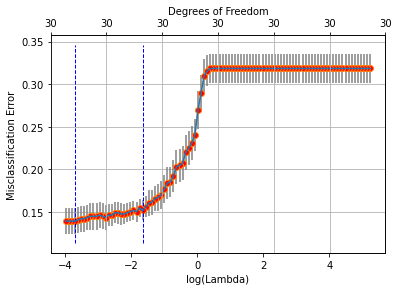

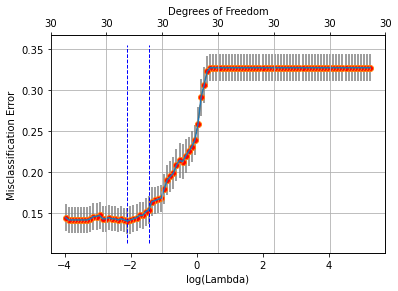

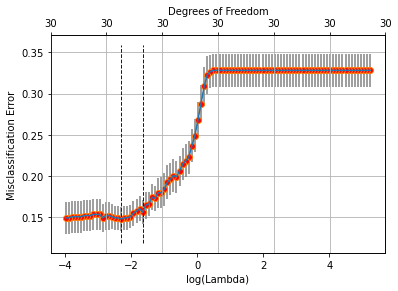

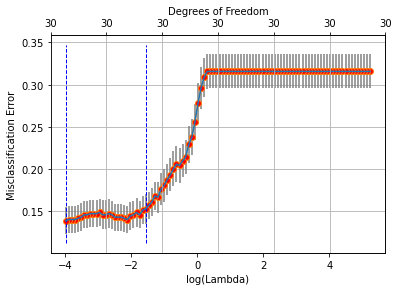

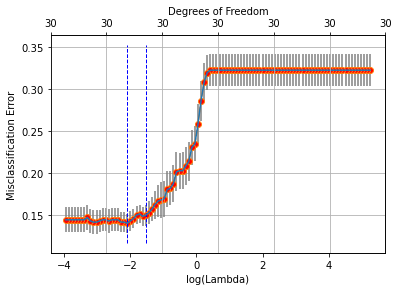

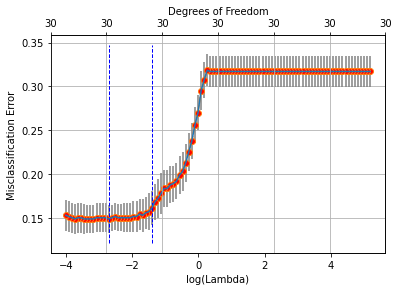

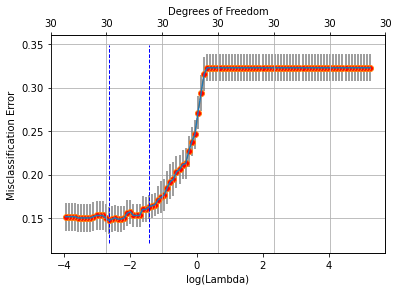

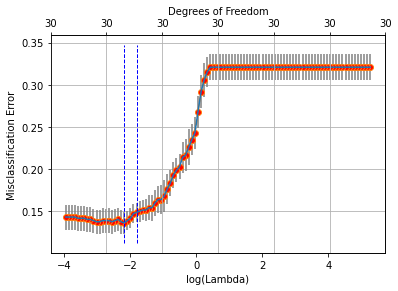

In [7]:
"""
Plots that decide the correct alpha
"""
plt.figure()
plt.plot(range(0,11),PyGLMscore_long, 'blue')  

cumulativeScore = PyGLMscore_long #+ PyGLMscore_v2_low + PyGLMscore_v2_high

[uniqueTonesSmall, betasSmall_v2_long, pyGLMbetasSmall_v2_long,
 scoreGLM_v2_long, scorePyGLM_v2_long] = betaValuesSim(trial_tones_expt,
                                                  trial_behaviour_expt,
                                                  alpha = (np.argmax(cumulativeScore))*0.1,
                                                  noTau=0, 
                                                  permutations=10)

alpha 0.0
glm scores for no context 0.8572626582278483 0.8672784810126583
Norm of distractor weights compared to norm of all weights no context 0.5432809050153597
Bias terms long context : -0.2517295348501213


Text(0.5, 1.0, 'Pyglmnet elastic net with Tikhonov smoothing, alpha = 0.0')

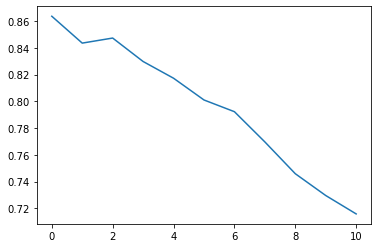

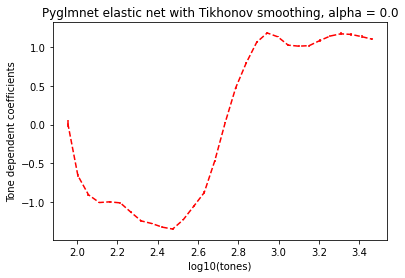

In [8]:
"""
Plots that check for smoothing due to tikhonov
"""
print('alpha',(np.argmax(cumulativeScore))*0.1)
print('glm scores for no context',scoreGLM_v2_long, scorePyGLM_v2_long)
plt.figure()
plt.plot(PyGLMscore_long)

plt.figure()
meanShift_long = np.mean(np.mean(pyGLMbetasSmall_v2_long[:,1:],axis=0))
glmWeights = np.mean(pyGLMbetasSmall_v2_long[:,1:],axis=0)-meanShift_long
plt.errorbar(np.log10(uniqueTonesSmall), glmWeights, np.std(pyGLMbetasSmall_v2_long[:,1:],axis=0)/np.sqrt(10), 
             color='red', ls='--')
bias = np.mean(pyGLMbetasSmall_v2_long[:,0]) + 3*meanShift_long

print("Norm of distractor weights compared to norm of all weights no context",
      (sum(np.abs(glmWeights[:8]))+sum(np.abs(glmWeights[-8:])))/sum(np.abs(glmWeights)))

pd.DataFrame(glmWeights).to_csv("figures/FromProlific/glms/glmsAcrossAllContexts/4fc3_lowContext_GLMWeights.csv")

print(f"Bias terms long context : {bias}")

plt.xlabel('log10(tones)')
plt.ylabel('Tone dependent coefficients')
plt.title(f'Pyglmnet elastic net with Tikhonov smoothing, alpha = {(np.argmax(cumulativeScore))*0.1}')
